# Conditional Self-Attention GAN
## Dipack P Panjabi, 50291077, dipackpr@buffalo.edu
Same as the Self-Attention GAN, except we also pass in labels to the generator and discriminator.

In [1]:
%matplotlib inline
import os
import shutil
import logging
import torch as t
import torch.nn as tnn
import torch.nn.functional as F
import torch.optim as toptimizer
import torch.backends.cudnn as tcudnn
import torchvision.utils as tutils
from modules import SelfAttention, FID
from util import setup_argparser, get_dataset, init_layer_weights, plot_losses, plot_fid_scores, clean_make_dir, save_best_generator_image, mean_fid

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s', datefmt='%d/%m/%Y %I:%M:%S %p',
                    level=logging.INFO)

In [2]:
class CSAGenerator(tnn.Module):
    def __init__(self, latent_size=100, num_classes=10, hidden_units=64):
        super(CSAGenerator, self).__init__()
        self.attn_layer = SelfAttention(hidden_units)
        self.l1_1 = tnn.Sequential(
            # Input layer for images
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(latent_size, out_channels=hidden_units * 4, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l1_2 = tnn.Sequential(
            # Input layer for labels
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(num_classes, out_channels=hidden_units * 4, kernel_size=4, stride=1, padding=0, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l2 = tnn.Sequential(
            # Layer 2
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(hidden_units * 8, hidden_units * 4, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 4),
            tnn.ReLU(True)
                )
        self.l3 = tnn.Sequential(
            # Layer 3
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(hidden_units * 4, hidden_units * 2, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units * 2),
            tnn.ReLU(True)
                )
        self.l4 = tnn.Sequential(
            # Layer 4
            tnn.utils.spectral_norm(tnn.ConvTranspose2d(hidden_units * 2, hidden_units, 4, 2, 1, bias=False)),
            tnn.BatchNorm2d(hidden_units),
            tnn.ReLU(True)
                )
        self.lout = tnn.Sequential(
            # Output Layer
            # CIFAR-10 reps RGB images, so there are 3 channels in the output
            # Changes made to the final layer to work with 32 * 32
            tnn.ConvTranspose2d(hidden_units, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            tnn.Tanh()
                )
        return

    def forward(self, x, y):
        x = self.l1_1(x)
        y = self.l1_2(y)
        output = t.cat((x, y), dim=1)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = self.attn_layer(output)
        output = self.lout(output)
        return output

class CSADiscriminator(tnn.Module):
    def __init__(self, num_classes=10, hidden_units=64):
        super(CSADiscriminator, self).__init__()
        self.num_hidden_units = hidden_units
        self.attn_layer = SelfAttention(hidden_units)
        self.l1_1 = tnn.Sequential(
                # Input layer for images
                tnn.utils.spectral_norm(tnn.Conv2d(in_channels=3, out_channels=hidden_units // 2, kernel_size=4, stride=2, padding=1, bias=False)),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l1_2 = tnn.Sequential(
                # Input layer for labels
                tnn.utils.spectral_norm(tnn.Conv2d(in_channels=num_classes, out_channels=hidden_units // 2, kernel_size=4, stride=2, padding=1, bias=False)),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l2 = tnn.Sequential(
                # Layer 1
                tnn.utils.spectral_norm(tnn.Conv2d(hidden_units, hidden_units * 2, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(hidden_units * 2),
                tnn.LeakyReLU(0.2, inplace=True)
                )
        self.l3 = tnn.Sequential(
                # Layer 2
                tnn.utils.spectral_norm(tnn.Conv2d(hidden_units * 2, hidden_units * 4, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(hidden_units * 4),
                tnn.LeakyReLU(0.2, inplace=True),
                )
        self.l4 = tnn.Sequential(
                # Layer 3
                tnn.utils.spectral_norm(tnn.Conv2d(hidden_units * 4, hidden_units * 8, 4, 2, 1, bias=False)),
                tnn.BatchNorm2d(hidden_units * 8),
                tnn.LeakyReLU(0.2, inplace=True),
                )
        self.lout = tnn.Sequential(
                # Output Layer
                tnn.Linear(4 * 4 * 4 * hidden_units, 1, bias=False)
                )
        return

    def forward(self, x, y):
        x = self.l1_1(x)
        y = self.l1_2(y)
        output = t.cat((x, y), dim=1)
        output = self.attn_layer(output)
        output = self.l2(output)
        output = self.l3(output)
        output = self.l4(output)
        output = output.view(-1, 4 * 4 * 4 * self.num_hidden_units)
        output = self.lout(output)
        return output

### Parameters

In [3]:
path             = "./cifar10"
output_path      = "./output/csagan"
learning_rate    = 0.0002
batch_size       = 32
latent_size      = 100
num_epochs       = 50
gen_hidden_units = 32
dis_hidden_units = 32
debug_info       = False
clean_dirs       = True
save_best        = True
log_interval     = 100
fid_batch_interval = 10

### Actual Model Run

21/10/2019 10:04:14 PM - INFO: Clean selected - removing: ./output/csagan
21/10/2019 10:04:14 PM - INFO: Creating output directory: ./output/csagan
21/10/2019 10:04:14 PM - INFO: Dataset path: ./cifar10, Output path: ./output/csagan, Batch Size: 32, Latent Size: 100, Num iterations: 50, Generator unit multiplier: 32, Discriminator unit multiplier: 32, Learning rate: 0.0002


Files already downloaded and verified
Files already downloaded and verified


21/10/2019 10:04:15 PM - INFO: CUDA enabled device found - will use CUDA device
21/10/2019 10:04:20 PM - INFO: CSAGenerator(
  (attn_layer): SelfAttention(
    (conv_query): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_key): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
    (conv_value): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (l1_1): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l1_2): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (l2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, mom

21/10/2019 10:13:42 PM - INFO: Epoch: 4/50, Sample: 101/1562, Disc Loss: 1.3839, Gen Loss: 1.1095
21/10/2019 10:13:49 PM - INFO: Epoch: 4/50, Sample: 201/1562, Disc Loss: 1.5476, Gen Loss: 1.4031
21/10/2019 10:13:55 PM - INFO: Epoch: 4/50, Sample: 301/1562, Disc Loss: 0.5113, Gen Loss: 0.3388
21/10/2019 10:14:02 PM - INFO: Epoch: 4/50, Sample: 401/1562, Disc Loss: 0.6367, Gen Loss: 0.7673
21/10/2019 10:14:08 PM - INFO: Epoch: 4/50, Sample: 501/1562, Disc Loss: 0.9915, Gen Loss: 0.7325
21/10/2019 10:14:15 PM - INFO: Epoch: 4/50, Sample: 601/1562, Disc Loss: 1.7018, Gen Loss: 2.2197
21/10/2019 10:14:21 PM - INFO: Epoch: 4/50, Sample: 701/1562, Disc Loss: 2.7704, Gen Loss: 0.4909
21/10/2019 10:14:27 PM - INFO: Epoch: 4/50, Sample: 801/1562, Disc Loss: 1.9070, Gen Loss: 0.7765
21/10/2019 10:14:34 PM - INFO: Epoch: 4/50, Sample: 901/1562, Disc Loss: 0.5732, Gen Loss: 1.2019
21/10/2019 10:14:40 PM - INFO: Epoch: 4/50, Sample: 1001/1562, Disc Loss: 1.8107, Gen Loss: 0.9438
21/10/2019 10:14:47

21/10/2019 10:29:20 PM - INFO: Epoch: 9/50, Sample: 101/1562, Disc Loss: 1.1694, Gen Loss: -0.1961
21/10/2019 10:29:27 PM - INFO: Epoch: 9/50, Sample: 201/1562, Disc Loss: 1.3240, Gen Loss: 0.3521
21/10/2019 10:29:33 PM - INFO: Epoch: 9/50, Sample: 301/1562, Disc Loss: 0.2703, Gen Loss: 1.1127
21/10/2019 10:29:39 PM - INFO: Epoch: 9/50, Sample: 401/1562, Disc Loss: 1.0656, Gen Loss: 1.6901
21/10/2019 10:29:46 PM - INFO: Epoch: 9/50, Sample: 501/1562, Disc Loss: 1.3916, Gen Loss: 1.1946
21/10/2019 10:29:52 PM - INFO: Epoch: 9/50, Sample: 601/1562, Disc Loss: 1.4717, Gen Loss: 0.8934
21/10/2019 10:29:59 PM - INFO: Epoch: 9/50, Sample: 701/1562, Disc Loss: 0.6157, Gen Loss: 2.4518
21/10/2019 10:30:05 PM - INFO: Epoch: 9/50, Sample: 801/1562, Disc Loss: 1.0152, Gen Loss: 2.5335
21/10/2019 10:30:12 PM - INFO: Epoch: 9/50, Sample: 901/1562, Disc Loss: 0.3193, Gen Loss: 0.3797
21/10/2019 10:30:18 PM - INFO: Epoch: 9/50, Sample: 1001/1562, Disc Loss: 0.7736, Gen Loss: 0.9729
21/10/2019 10:30:2

21/10/2019 10:45:07 PM - INFO: Epoch: 14/50, Sample: 101/1562, Disc Loss: 1.1349, Gen Loss: 1.5128
21/10/2019 10:45:13 PM - INFO: Epoch: 14/50, Sample: 201/1562, Disc Loss: 0.5317, Gen Loss: 2.4398
21/10/2019 10:45:20 PM - INFO: Epoch: 14/50, Sample: 301/1562, Disc Loss: 0.4122, Gen Loss: 0.9162
21/10/2019 10:45:27 PM - INFO: Epoch: 14/50, Sample: 401/1562, Disc Loss: 0.6944, Gen Loss: 1.0465
21/10/2019 10:45:34 PM - INFO: Epoch: 14/50, Sample: 501/1562, Disc Loss: 0.4974, Gen Loss: -0.6457
21/10/2019 10:45:40 PM - INFO: Epoch: 14/50, Sample: 601/1562, Disc Loss: 0.2630, Gen Loss: 1.1598
21/10/2019 10:45:47 PM - INFO: Epoch: 14/50, Sample: 701/1562, Disc Loss: 0.7470, Gen Loss: 1.6015
21/10/2019 10:45:53 PM - INFO: Epoch: 14/50, Sample: 801/1562, Disc Loss: 0.5204, Gen Loss: 1.6523
21/10/2019 10:46:00 PM - INFO: Epoch: 14/50, Sample: 901/1562, Disc Loss: 1.3173, Gen Loss: 1.8972
21/10/2019 10:46:07 PM - INFO: Epoch: 14/50, Sample: 1001/1562, Disc Loss: 0.3858, Gen Loss: 1.3238
21/10/20

21/10/2019 11:01:23 PM - INFO: Epoch: 19/50, Sample: 101/1562, Disc Loss: 0.1411, Gen Loss: 3.2013
21/10/2019 11:01:30 PM - INFO: Epoch: 19/50, Sample: 201/1562, Disc Loss: 1.1063, Gen Loss: 3.1357
21/10/2019 11:01:37 PM - INFO: Epoch: 19/50, Sample: 301/1562, Disc Loss: 1.0190, Gen Loss: 0.7014
21/10/2019 11:01:44 PM - INFO: Epoch: 19/50, Sample: 401/1562, Disc Loss: 0.3853, Gen Loss: -0.0071
21/10/2019 11:01:51 PM - INFO: Epoch: 19/50, Sample: 501/1562, Disc Loss: 0.1642, Gen Loss: 1.5546
21/10/2019 11:01:57 PM - INFO: Epoch: 19/50, Sample: 601/1562, Disc Loss: 0.3275, Gen Loss: 1.2358
21/10/2019 11:02:04 PM - INFO: Epoch: 19/50, Sample: 701/1562, Disc Loss: 0.5429, Gen Loss: 2.9059
21/10/2019 11:02:11 PM - INFO: Epoch: 19/50, Sample: 801/1562, Disc Loss: 0.3295, Gen Loss: 1.9785
21/10/2019 11:02:18 PM - INFO: Epoch: 19/50, Sample: 901/1562, Disc Loss: 0.2375, Gen Loss: 2.1127
21/10/2019 11:02:25 PM - INFO: Epoch: 19/50, Sample: 1001/1562, Disc Loss: 0.1268, Gen Loss: 1.2916
21/10/20

21/10/2019 11:17:23 PM - INFO: Epoch: 24/50, Sample: 101/1562, Disc Loss: 0.4520, Gen Loss: 1.4212
21/10/2019 11:17:30 PM - INFO: Epoch: 24/50, Sample: 201/1562, Disc Loss: 0.1977, Gen Loss: 2.8926
21/10/2019 11:17:36 PM - INFO: Epoch: 24/50, Sample: 301/1562, Disc Loss: 0.4830, Gen Loss: 1.8267
21/10/2019 11:17:43 PM - INFO: Epoch: 24/50, Sample: 401/1562, Disc Loss: 0.4465, Gen Loss: 1.9225
21/10/2019 11:17:50 PM - INFO: Epoch: 24/50, Sample: 501/1562, Disc Loss: 0.5543, Gen Loss: 2.0819
21/10/2019 11:17:56 PM - INFO: Epoch: 24/50, Sample: 601/1562, Disc Loss: 1.2657, Gen Loss: 1.8249
21/10/2019 11:18:03 PM - INFO: Epoch: 24/50, Sample: 701/1562, Disc Loss: 0.4688, Gen Loss: 1.1652
21/10/2019 11:18:09 PM - INFO: Epoch: 24/50, Sample: 801/1562, Disc Loss: 1.5467, Gen Loss: 3.4880
21/10/2019 11:18:16 PM - INFO: Epoch: 24/50, Sample: 901/1562, Disc Loss: 0.3470, Gen Loss: 2.2949
21/10/2019 11:18:22 PM - INFO: Epoch: 24/50, Sample: 1001/1562, Disc Loss: 0.5199, Gen Loss: 1.4755
21/10/201

21/10/2019 11:32:45 PM - INFO: Epoch: 29/50, Sample: 101/1562, Disc Loss: 0.2379, Gen Loss: 2.1721
21/10/2019 11:32:52 PM - INFO: Epoch: 29/50, Sample: 201/1562, Disc Loss: 0.0973, Gen Loss: 2.2588
21/10/2019 11:32:58 PM - INFO: Epoch: 29/50, Sample: 301/1562, Disc Loss: 0.0491, Gen Loss: -1.2526
21/10/2019 11:33:05 PM - INFO: Epoch: 29/50, Sample: 401/1562, Disc Loss: 0.0448, Gen Loss: 3.0727
21/10/2019 11:33:11 PM - INFO: Epoch: 29/50, Sample: 501/1562, Disc Loss: 0.0749, Gen Loss: 1.3282
21/10/2019 11:33:18 PM - INFO: Epoch: 29/50, Sample: 601/1562, Disc Loss: 0.1824, Gen Loss: 1.6033
21/10/2019 11:33:24 PM - INFO: Epoch: 29/50, Sample: 701/1562, Disc Loss: 0.6169, Gen Loss: 2.3993
21/10/2019 11:33:31 PM - INFO: Epoch: 29/50, Sample: 801/1562, Disc Loss: 0.6561, Gen Loss: 2.7989
21/10/2019 11:33:37 PM - INFO: Epoch: 29/50, Sample: 901/1562, Disc Loss: 1.8744, Gen Loss: 1.1464
21/10/2019 11:33:44 PM - INFO: Epoch: 29/50, Sample: 1001/1562, Disc Loss: 0.5573, Gen Loss: 0.5236
21/10/20

21/10/2019 11:47:37 PM - INFO: Epoch: 34/50, Sample: 101/1562, Disc Loss: 0.6535, Gen Loss: 3.6906
21/10/2019 11:47:44 PM - INFO: Epoch: 34/50, Sample: 201/1562, Disc Loss: 0.1958, Gen Loss: 1.3718
21/10/2019 11:47:50 PM - INFO: Epoch: 34/50, Sample: 301/1562, Disc Loss: 0.3444, Gen Loss: 0.4715
21/10/2019 11:47:57 PM - INFO: Epoch: 34/50, Sample: 401/1562, Disc Loss: 1.3316, Gen Loss: 3.8805
21/10/2019 11:48:04 PM - INFO: Epoch: 34/50, Sample: 501/1562, Disc Loss: 0.1398, Gen Loss: 2.2495
21/10/2019 11:48:10 PM - INFO: Epoch: 34/50, Sample: 601/1562, Disc Loss: 0.6575, Gen Loss: 2.1154
21/10/2019 11:48:16 PM - INFO: Epoch: 34/50, Sample: 701/1562, Disc Loss: 0.4276, Gen Loss: 1.7895
21/10/2019 11:48:23 PM - INFO: Epoch: 34/50, Sample: 801/1562, Disc Loss: 1.0395, Gen Loss: 1.9375
21/10/2019 11:48:29 PM - INFO: Epoch: 34/50, Sample: 901/1562, Disc Loss: 0.1111, Gen Loss: 2.1099
21/10/2019 11:48:36 PM - INFO: Epoch: 34/50, Sample: 1001/1562, Disc Loss: 0.1243, Gen Loss: 1.1382
21/10/201

22/10/2019 12:02:21 AM - INFO: Epoch: 39/50, Sample: 101/1562, Disc Loss: 0.3611, Gen Loss: 2.8040
22/10/2019 12:02:28 AM - INFO: Epoch: 39/50, Sample: 201/1562, Disc Loss: 0.5531, Gen Loss: 2.4520
22/10/2019 12:02:34 AM - INFO: Epoch: 39/50, Sample: 301/1562, Disc Loss: 0.1082, Gen Loss: 2.3891
22/10/2019 12:02:40 AM - INFO: Epoch: 39/50, Sample: 401/1562, Disc Loss: 0.1102, Gen Loss: 2.0862
22/10/2019 12:02:47 AM - INFO: Epoch: 39/50, Sample: 501/1562, Disc Loss: 0.4680, Gen Loss: 3.5400
22/10/2019 12:02:53 AM - INFO: Epoch: 39/50, Sample: 601/1562, Disc Loss: 0.1057, Gen Loss: 2.3751
22/10/2019 12:03:00 AM - INFO: Epoch: 39/50, Sample: 701/1562, Disc Loss: 0.2715, Gen Loss: 1.6447
22/10/2019 12:03:06 AM - INFO: Epoch: 39/50, Sample: 801/1562, Disc Loss: 1.1410, Gen Loss: 2.5010
22/10/2019 12:03:13 AM - INFO: Epoch: 39/50, Sample: 901/1562, Disc Loss: 0.5139, Gen Loss: 3.9693
22/10/2019 12:03:19 AM - INFO: Epoch: 39/50, Sample: 1001/1562, Disc Loss: 0.3049, Gen Loss: 4.9013
22/10/201

22/10/2019 12:17:07 AM - INFO: Epoch: 44/50, Sample: 101/1562, Disc Loss: 0.6294, Gen Loss: 3.6136
22/10/2019 12:17:13 AM - INFO: Epoch: 44/50, Sample: 201/1562, Disc Loss: 0.1825, Gen Loss: 3.1078
22/10/2019 12:17:20 AM - INFO: Epoch: 44/50, Sample: 301/1562, Disc Loss: 0.3056, Gen Loss: 2.1015
22/10/2019 12:17:26 AM - INFO: Epoch: 44/50, Sample: 401/1562, Disc Loss: 0.1392, Gen Loss: 1.6855
22/10/2019 12:17:32 AM - INFO: Epoch: 44/50, Sample: 501/1562, Disc Loss: 0.0881, Gen Loss: 2.5313
22/10/2019 12:17:39 AM - INFO: Epoch: 44/50, Sample: 601/1562, Disc Loss: 0.5916, Gen Loss: 1.9130
22/10/2019 12:17:45 AM - INFO: Epoch: 44/50, Sample: 701/1562, Disc Loss: 0.5585, Gen Loss: 5.1912
22/10/2019 12:17:52 AM - INFO: Epoch: 44/50, Sample: 801/1562, Disc Loss: 0.1268, Gen Loss: 3.0509
22/10/2019 12:17:59 AM - INFO: Epoch: 44/50, Sample: 901/1562, Disc Loss: 0.3941, Gen Loss: 3.0844
22/10/2019 12:18:05 AM - INFO: Epoch: 44/50, Sample: 1001/1562, Disc Loss: 0.6114, Gen Loss: 4.6781
22/10/201

22/10/2019 12:31:54 AM - INFO: Epoch: 49/50, Sample: 101/1562, Disc Loss: 0.0494, Gen Loss: 1.0600
22/10/2019 12:32:01 AM - INFO: Epoch: 49/50, Sample: 201/1562, Disc Loss: 0.5775, Gen Loss: 3.1394
22/10/2019 12:32:07 AM - INFO: Epoch: 49/50, Sample: 301/1562, Disc Loss: 0.0408, Gen Loss: 4.8768
22/10/2019 12:32:14 AM - INFO: Epoch: 49/50, Sample: 401/1562, Disc Loss: 0.1379, Gen Loss: 4.1032
22/10/2019 12:32:20 AM - INFO: Epoch: 49/50, Sample: 501/1562, Disc Loss: 0.1526, Gen Loss: 3.0693
22/10/2019 12:32:27 AM - INFO: Epoch: 49/50, Sample: 601/1562, Disc Loss: 0.6071, Gen Loss: 2.9921
22/10/2019 12:32:33 AM - INFO: Epoch: 49/50, Sample: 701/1562, Disc Loss: 0.5219, Gen Loss: 3.3488
22/10/2019 12:32:40 AM - INFO: Epoch: 49/50, Sample: 801/1562, Disc Loss: 0.6777, Gen Loss: 2.9523
22/10/2019 12:32:46 AM - INFO: Epoch: 49/50, Sample: 901/1562, Disc Loss: 0.0760, Gen Loss: 3.1547
22/10/2019 12:32:53 AM - INFO: Epoch: 49/50, Sample: 1001/1562, Disc Loss: 0.4971, Gen Loss: 1.8772
22/10/201

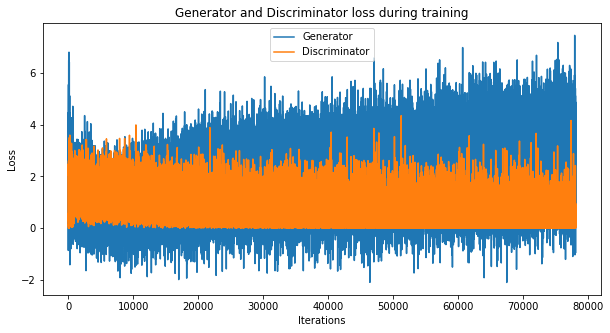

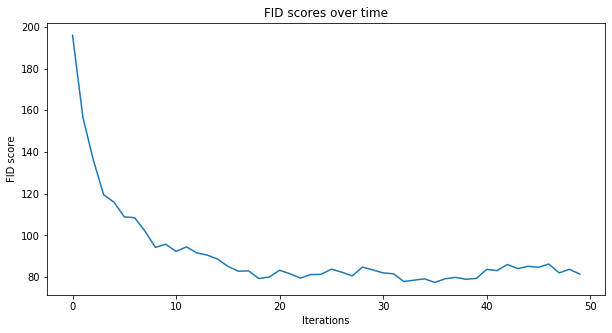

In [4]:
# Number of classes in CIFAR-10 dataset
num_classes = 10

if clean_dirs:
    clean_make_dir(output_path)

logging.info("Dataset path: {}, Output path: {}, Batch Size: {}, Latent Size: {}, Num iterations: {}, Generator unit multiplier: {}, Discriminator unit multiplier: {}, Learning rate: {}".format(path, output_path, batch_size, latent_size, num_epochs, gen_hidden_units, dis_hidden_units, learning_rate))

training_dataset = get_dataset(path, train=True)
# Dropping the last batch as it is sometimes not divisible by batch_size,
# causing errors when trying to feed it to the GAN.
training_data_loader = t.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_dataset_path = "{0}/test".format(path)
testing_dataset = get_dataset(testing_dataset_path, train=False)
testing_data_loader = t.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
testing_data_iter = iter(testing_data_loader)

device = t.device("cpu")
if t.cuda.is_available():
    logging.info("CUDA enabled device found - will use CUDA device")
    device = t.device("cuda:0")

# Init FID calculator
fid_calculator = FID(device=device)

gen_weights = None
generator = CSAGenerator(latent_size=latent_size, num_classes=num_classes, hidden_units=gen_hidden_units).to(device)
generator.apply(init_layer_weights)
if gen_weights is not None:
    logging.info("Using weights saved at {} to continue Generator training".format(gen_weights))
    generator.load_state_dict(t.load(gen_weights))

dis_weights = None
discriminator = CSADiscriminator(num_classes=num_classes, hidden_units=dis_hidden_units).to(device)
discriminator.apply(init_layer_weights)
if dis_weights is not None:
    logging.info("Using weights saved at {} to continue Discriminator training".format(dis_weights))
    discriminator.load_state_dict(t.load(dis_weights))

logging.info(generator)
logging.info(discriminator)

fixed_c = t.randint(0, num_classes, (batch_size, 1))
fixed_noise = t.randn(batch_size, latent_size, 1, 1).to(device=device)

# One-hotted fixed label vector
fixed_label = t.zeros(batch_size, num_classes)
fixed_label.scatter_(1, fixed_c.type(t.LongTensor), 1)
fixed_label = fixed_label.view(-1, num_classes, 1, 1).to(device=device)

# Label preprocess
onehot = t.zeros(num_classes, num_classes)
onehot = onehot.scatter_(1, t.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(num_classes, 1), 1).view(num_classes, num_classes, 1, 1)
# Here 32 represents the image dimension
fill = t.zeros([num_classes, num_classes, 32, 32]).to(device=device)
for idx in range(num_classes):
    fill[idx, idx, :, :] = 1

# Discriminator and Generator should have different learning rates
dis_optimizer = toptimizer.Adam(discriminator.parameters(), lr=learning_rate*4, betas=(0.5, 0.999))
gen_optimizer = toptimizer.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

gen_filenames = []
gen_losses = []
dis_losses = []
fid_scores = []

# START - Training epoch loop
for epoch in range(num_epochs):
    # Variables to hold generated and fake images for FID score calc
    real_image_batch, fake_image_batch = None, None
    # START - Training batch loop
    for idx, data in enumerate(training_data_loader, start=0):
        # DISCRIMINATOR
        # Train discriminator network
        discriminator.zero_grad()
        # Real data
        real_images = data[0].to(device)
        real_labels = data[1].to(device=device)
        # Batch size
        bs = real_images.size(0)

        # Create real, fake, and filled labels
        y_real = t.ones(bs).to(device=device)
        y_fake = t.zeros(bs).to(device=device)
        c_fill = fill[real_labels].to(device=device)

        output = discriminator(real_images, c_fill)
        # Hinge loss
        dis_err_real = F.relu(1.0 - output).mean()
        # Discriminator output mean for real images
        D_x = output.mean().item()

        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        epoch_labels = (t.rand(bs, 1) * num_classes).type(t.LongTensor).squeeze()
        epoch_labels_onehot = onehot[epoch_labels].to(device=device)
        # Generate fake images using noise
        fake_images = generator(epoch_noise, epoch_labels_onehot)
        # Discriminator output for fake images
        c_fill = fill[epoch_labels].to(device=device)
        output = discriminator(fake_images.detach(), c_fill)
        # Hinge loss
        dis_err_fake = F.relu(1.0 + output).mean()
        # Discriminator output mean for fake images - before discriminator update
        D_G_z1 = output.mean().item()
        dis_err = dis_err_real + dis_err_fake
        discriminator.zero_grad()
        dis_err.backward()
        dis_optimizer.step()

        # GENERATOR
        # Train with fake data
        epoch_noise = t.randn(batch_size, latent_size, 1, 1, device=device)
        epoch_labels = (t.rand(bs, 1) * num_classes).type(t.LongTensor).squeeze()
        epoch_labels_onehot = onehot[epoch_labels].to(device=device)
        fake_images = generator(epoch_noise, epoch_labels_onehot)
        # Test discriminator again - this time after training it
        c_fill = fill[epoch_labels].to(device=device)
        output = discriminator(fake_images, c_fill)
        # Hinge loss
        gen_err = - output.mean()
        generator.zero_grad()
        gen_err.backward()
        # Discriminator output mean for fake images - after discriminator update
        D_G_z2 = output.mean().item()
        gen_optimizer.step()

        gen_losses.append(gen_err.item())
        dis_losses.append(dis_err.item())

        if idx % log_interval == 0:
            log_info = "Epoch: {}/{}, Sample: {}/{}, Disc Loss: {:.4f}, Gen Loss: {:.4f}".format(epoch + 1, num_epochs, idx + 1, len(training_data_loader), dis_err.item(), gen_err.item())
            if debug_info:
                log_info += ", D(x): {:.4f}, D(G(z)): {:.4f} / {:.4f}".format(D_x, D_G_z1, D_G_z2)
            logging.info(log_info)

        if idx % 100 == 0 or idx == (len(training_data_loader) - 1):
            tutils.save_image(real_images, "{0}/real_samples.png".format(output_path), normalize=True)
            fake_images = generator(fixed_noise, fixed_label)
            tutils.save_image(fake_images.detach(), "{0}/fake_samples_epoch_{1}.png".format(output_path, epoch + 1), normalize=True)

        if idx % fid_batch_interval == 0:
            # Add to fake image batch for FID score calc
            fake_images = generator(fixed_noise, fixed_label)
            if fake_image_batch is None:
                fake_image_batch = fake_images.detach()
            else:
                fake_image_batch = t.cat((fake_image_batch, fake_images.detach()), dim=0)
    # END - Training batch loop

    g_weight_filename = "{0}/generator_epoch_{1}.pth".format(output_path, epoch + 1)
    gen_filenames.append(g_weight_filename)
    # Checkpoint model
    t.save(generator.state_dict(), g_weight_filename)
    t.save(discriminator.state_dict(), "{0}/discriminator_epoch_{1}.pth".format(output_path, epoch + 1))

    # Save attention map
    tutils.save_image(discriminator.attn_layer.get_attention(as_image=True), "{0}/discriminator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)
    tutils.save_image(generator.attn_layer.get_attention(as_image=True), "{0}/generator_attention_epoch_{1}.png".format(output_path, epoch), normalize=True)

    # Calculate FID scores after each epoch - as it is super slow during normal iterations
    while real_image_batch is None or len(real_image_batch) < len(fake_image_batch):
        try:
            r_im, r_labels = next(testing_data_iter)
            r_im.to(device=device)
            r_labels.to(device=device)
            onehot_r_labels = onehot[r_labels].to(device=device)
            for oh_fixed_label in fixed_label:
                # Find out which real images belong to each fixed label
                indexes = (onehot_r_labels.squeeze() == oh_fixed_label.squeeze()).all(dim=1)
                c_images = r_im[indexes]
                if real_image_batch is None:
                    real_image_batch = c_images
                else:
                    real_image_batch = t.cat((real_image_batch, c_images), dim=0)
        except StopIteration:
            testing_data_iter = iter(testing_data_loader)
    # We need to perform this truncation to prevent as our while loop above does not do it
    real_image_batch = real_image_batch[:len(fake_image_batch)]
    fid_score = fid_calculator.calculate_fid(real_image_batch, fake_image_batch, batch_size)
    fid_scores.append(fid_score)
    logging.info("Epoch {} FID score: {}".format(epoch + 1, fid_score))
# END - Training epoch loop

logging.info("FID scores over the epochs: {}".format(fid_scores))
logging.info("Mean FID score: {}".format(mean_fid(fid_scores)))
plot_losses(gen_losses, dis_losses)
plot_fid_scores(fid_scores)

In [5]:
from numpy import argmin
if save_best:
    best_gen_weights = gen_filenames[argmin(fid_scores)]
    logging.info("Generator model with lowest FID score is {}".format(best_gen_weights))
    generator.load_state_dict(t.load(best_gen_weights))
    best_fake_image_path = "{0}/best_fake_sample.png".format(output_path)
    logging.info("Saving output of best generator model to {}".format(best_fake_image_path))
    tutils.save_image(generator(fixed_noise, fixed_label).detach(), best_fake_image_path, normalize=True)

22/10/2019 12:37:44 AM - INFO: Generator model with lowest FID score is ./output/csagan/generator_epoch_36.pth
22/10/2019 12:37:44 AM - INFO: Saving output of best generator model to ./output/csagan/best_fake_sample.png


22/10/2019 12:37:44 AM - INFO: Last image generated


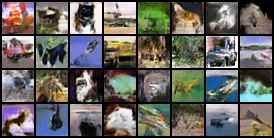

22/10/2019 12:37:44 AM - INFO: Image generated from model with lowest FID score


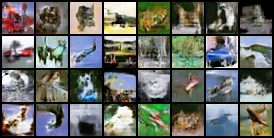

In [6]:
from IPython.display import Image, display

logging.info("Last image generated")
display(Image(filename="{0}/fake_samples_epoch_{1}.png".format(output_path, num_epochs)))
if save_best:
    logging.info("Image generated from model with lowest FID score")
    display(Image(filename="{0}/best_fake_sample.png".format(output_path)))